TODO:
explain
Import libraries
Calculate K and D from lensCalibration
Calculate pixel size to height ratio from pixelCalibration
Calculate pixel size for image
    Test images
    Import video, alt file, and frame
Output tiff

In [2]:
import cv2
assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'
import numpy as np
import os
import glob
import PIL.Image

from matplotlib import pyplot as plt
from IPython.display import display, Image
import math

CHECKERBOARD = (6,9)

In [1]:


subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('*.png')

for fname in images:
    print ("processing:", fname)
    img = cv2.imread(fname)
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."
        
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)
        
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
rms, _, _, _, _ = cv2.fisheye.calibrate(objpoints,imgpoints,gray.shape[::-1],K,D,rvecs,tvecs,calibration_flags,(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))
print("Found " + str(N_OK) + " valid images for calibration")
print("DIM=" + str(_img_shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

processing: vlcsnap-2019-03-29-11h22m18s976.png
processing: vlcsnap-2019-03-29-11h22m29s950.png
processing: vlcsnap-2019-03-29-11h22m41s842.png
processing: vlcsnap-2019-03-29-11h22m51s335.png
processing: vlcsnap-2019-03-29-11h23m05s854.png
processing: vlcsnap-2019-03-29-11h24m07s159.png
processing: vlcsnap-2019-03-29-11h24m19s930.png
processing: vlcsnap-2019-03-29-11h24m29s221.png
Found 7 valid images for calibration
DIM=(3840, 2160)
K=np.array([[2169.734814264393, 0.0, 1825.0325299915667], [0.0, 2170.3863683272534, 1047.7182038574515], [0.0, 0.0, 1.0]])
D=np.array([[0.22333487104508568], [0.04861684426529506], [-0.026849346458128323], [-0.05077529676689974]])


(1723.4508, 1227.4856) (2029.6005, 753.2329) 564.4849182806511
Height to Pixel ratio:  0.0004951471625520002
pixel size:  0.3985934658543602


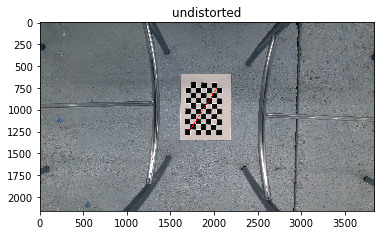

In [3]:
DIM=(3840, 2160)
K=np.array([[2169.734814264393, 0.0, 1825.0325299915667], [0.0, 2170.3863683272534, 1047.7182038574515], [0.0, 0.0, 1.0]])
D=np.array([[0.22333487104508568], [0.04861684426529506], [-0.026849346458128323], [-0.05077529676689974]])

img = cv2.imread('pixelCalibration/805mm.png')
h,w = img.shape[:2]
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

gray = cv2.cvtColor(undistorted_img,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
#print(corners)

#for i in corners:
#    cv2.circle(undistorted_img, tuple(i[0]), 20, (0,0,255), -1)

# Find the pixel distance between the farthest corners of the checkerboard
p1 = 0
p2 = 0
longdist = 0
for i in corners:
    for j in corners:
        dist = math.hypot(j[0][0] - i[0][0], j[0][1] - i[0][1])
        if dist > longdist:
            p1 = tuple(i[0])
            p2 = tuple(j[0])
            longdist = dist
            
print(p1,p2,longdist)
cv2.line(undistorted_img,p1,p2,(255,0,0),5)

pixelSize = 225.0/longdist #pixel size in mm

# ratio to go from alt to pixel size (unitless) constant for camera (I think)
height2pixel = pixelSize/805.0

print("Height to Pixel ratio: ",height2pixel)
print ("pixel size: ",height2pixel*805)
        
plt.imshow(undistorted_img)
plt.title("undistorted")
plt.show()

#cv2.imwrite("undistorted.png", undistorted_img)
#Image(filename='undistorted.png') 



In [53]:
import piexif
exif_dict = piexif.load("test2.tif")
thumbnail = exif_dict.pop("thumbnail")
if thumbnail is not None:
    with open("thumbnail.jpg", "wb+") as f:
        f.write(thumbnail)
for ifd_name in exif_dict:
    print("\n{0} IFD:".format(ifd_name))
    for key in exif_dict[ifd_name]:
        try:
            print(key, exif_dict[ifd_name][key][:10])
        except:
            print(key, exif_dict[ifd_name][key])



0th IFD:
256 3840
257 2160
258 (8, 8, 8)
259 1
262 2
273 192
277 3
278 2160
279 24883200
282 (25087807, 1000000)
283 (25087807, 1000000)
284 1
296 3

Exif IFD:

GPS IFD:

Interop IFD:

1st IFD:


282 (25087807, 1000000) = 25.08... pixels per cm

283 (25087807, 1000000)

296 3                       3 means cm 

In [42]:
zeroth_ifd = {piexif.ImageIFD.NewSubfileType: 0,
              piexif.ImageIFD.ImageWidth: 3840,
              piexif.ImageIFD.ImageLength: 2160,
              piexif.ImageIFD.BitsPerSample: (8, 8, 8),
              piexif.ImageIFD.PhotometricInterpretation: 2,
              piexif.ImageIFD.ImageDescription: b'ImageJ=1.5',
              piexif.ImageIFD.StripOffsets: 386,
              piexif.ImageIFD.SamplesPerPixel: 3,
              piexif.ImageIFD.RowsPerStrip: 2160,
              piexif.ImageIFD.StripByteCounts: 24883200,
              piexif.ImageIFD.XResolution: (25087807, 1000001),
              piexif.ImageIFD.YResolution: (25087807, 1000001),
              piexif.ImageIFD.ResolutionUnit: 3,
              }


exif_dict = {"0th":zeroth_ifd,"thumbnail":None}
piexif.insert(piexif.dump(exif_dict), "uncalibrated.jpg")

exif_dict = piexif.load("uncalibrated.jpg")
thumbnail = exif_dict.pop("thumbnail")
if thumbnail is not None:
    with open("thumbnail.jpg", "wb+") as f:
        f.write(thumbnail)
for ifd_name in exif_dict:
    print("\n{0} IFD:".format(ifd_name))
    for key in exif_dict[ifd_name]:
        try:
            print(key, exif_dict[ifd_name][key][:10])
        except:
            print(key, exif_dict[ifd_name][key])


0th IFD:
254 0
256 3840
257 2160
258 (8, 8, 8)
262 2
270 b'ImageJ=1.5'
273 386
277 3
278 2160
279 24883200
282 (25087807, 1000001)
283 (25087807, 1000001)
296 3

Exif IFD:

GPS IFD:

Interop IFD:

1st IFD:


In [6]:
#im = PIL.Image.open("test.tif")
im_pil = PIL.Image.fromarray(undistorted_img)
im_pil.save('test3.tif',
        x_resolution = 25.087807, # pixels per cm
        y_resolution = 25.087807, # pixels per cm
        resolution_unit = 3 ) # unit = cm